### Introduction

This Jupyter Notebook aims to analyze a dataset obtained from the OPERA detector, consisting of 817 muon neutrino interactions with a lead target. These interactions involve charged-current interactions of muon neutrinos, where a muon is reconstructed in the final state. During these interactions, various hadrons are produced when muon neutrinos interact with nucleons in the lead target.

The dataset provides detailed information about the neutrino interaction vertices, which denote the origin points of each event. These vertices indicate where the neutrino initially interacts with the detector, leading to the creation of other particles. Additionally, the dataset includes emulsion tracks resulting from these interactions, which trace the trajectories of particles generated during the event. These tracks typically form due to the neutrino's interaction with the material in the detector.

By visualizing the interaction vertices and track in a 3D context, this analysis aims to provide a comprehensive understanding of the physical events captured by the OPERA detector. Given that each event includes a reconstructed muon in the final state, the analysis will also focus on developing a machine learning algorithm. This algorithm aims to create a classifier specifically designed to identify muons within the dataset, enhancing our ability to interpret and analyze the muon neutrino interactions recorded by the OPERA detector.

### Importing libraries

In [1]:
import os  # For operating system related functionalities
import pandas as pd  # For data manipulation and analysis with DataFrames
import matplotlib.pyplot as plt  # For plotting graphs
from mpl_toolkits.mplot3d import Axes3D  # For 3D plotting
import seaborn as sns  # For statistical data visualization
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split  # For splitting data into train and test sets
from imblearn.over_sampling import SMOTE  # Import SMOTE for oversampling to handle class imbalance
from pycaret.classification import *  # For automated machine learning with PyCaret
from sklearn.tree import DecisionTreeClassifier  # For creating decision tree models
from sklearn.model_selection import StratifiedKFold  # For stratified cross-validation
from sklearn.metrics import classification_report  # For classification metrics report
from sklearn.model_selection import RandomizedSearchCV  # For randomized hyperparameter search
from scipy.stats import randint  # For random integer distribution for hyperparameter search
import numpy as np  # For array manipulation and numerical operations
from sklearn.metrics import make_scorer  # For creating custom scoring functions
from skopt import BayesSearchCV  # For Bayesian hyperparameter optimization
from skopt.space import Real, Categorical, Integer  # For defining hyperparameter search spaces
from sklearn.ensemble import RandomForestClassifier  # For creating random forest models
from sklearn.metrics import roc_curve, auc  # For ROC curve and AUC
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay  # For confusion matrix and its display
from sklearn.ensemble import RandomForestClassifier, VotingClassifier # For creating random forest models and voting classifiers
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, classification_report # For various model evaluation metrics
import mlflow  # Import the MLflow library for tracking machine learning experiments
import mlflow.sklearn  # Import the MLflow module for logging and loading scikit-learn models
from mlflow.tracking import MlflowClient  # Import the MlflowClient class for managing model versions and other tracking functionalities

In [2]:
import warnings  # Import the warnings module

# Ignore all warnings
warnings.filterwarnings('ignore')

### Loading track data

In [3]:
# Directory where the files are located
directory = 'data/NuMuSample_EmulsionDataset'

# Dictionary to store the DataFrames of each event
dataframes_events = {}

# Iterate over the files in the directory
for file in os.listdir(directory):
    if file.endswith('_Tracks.csv'):
        # Extract the event name from the file title
        event_name = file.split('_Tracks.csv')[0]
        # Read the CSV file and add it to the event dictionary
        file_path = os.path.join(directory, file)
        df_event = pd.read_csv(file_path)
        dataframes_events[event_name] = df_event

# Concatenate all event DataFrames into a single DataFrame
events = pd.concat(dataframes_events, ignore_index=True)

In [4]:
events

,trType,posX,posY,posZ,slopeXZ,slopeYZ
0,2,11889.9,61479.9,42595.0,0.0578,-0.0217
1,1,11662.8,61623.4,37391.0,0.1232,0.0187
2,2,11434.2,61727.6,38679.0,-0.0790,0.0627
3,2,11689.6,62020.4,38679.0,0.0502,0.2173
4,2,11622.6,61757.4,37391.0,0.0613,0.2266
...,...,...,...,...,...,...
3292,4,86183.1,35075.6,72285.0,0.1680,-0.2197
3293,6,86077.6,35154.8,72285.0,0.1638,-0.3143
3294,2,3425.6,29040.6,49146.0,0.4070,0.1144
3295,1,3394.1,29052.2,49146.0,0.0379,0.2370


The column `trType` represents the type of track detected, with each number corresponding to a specific type of particle recorded by the detector: 1 - muon; 2 - hadron; 3 - electron; 4 - black; 5 - back black; 6 - gray; 7 - back gray.

### Choosing the event ID

In [5]:
# Prompt the user to enter a desired event number and store it in the variable event_number
event_number = input("Enter the desired event number: ")

Enter the desired event number:  10140111072


In [6]:
# Check if the event number is present in the dictionary
if event_number in dataframes_events:
    # Access the DataFrame of the specific event
    df_event = dataframes_events[event_number]

    # Now you can use df_event to perform any operation you want with the DataFrame
    print(df_event)
else:
    print("The specified event number was not found.")

   trType     posX     posY   posZ  slopeXZ  slopeYZ
0       2  82325.3  67979.2  32221  -0.0088   0.0929
1       1  81525.1  68241.9  34831  -0.2380   0.0881
2       2  82193.3  68095.9  32243  -0.1797   0.2266
3       2  82435.4  67944.5  32243   0.1205   0.0361
4       3  82340.2  67437.5  34831   0.0018  -0.1514
5       3  82849.3  69071.7  36129   0.1093   0.2489


## Visualizing particle trajectories

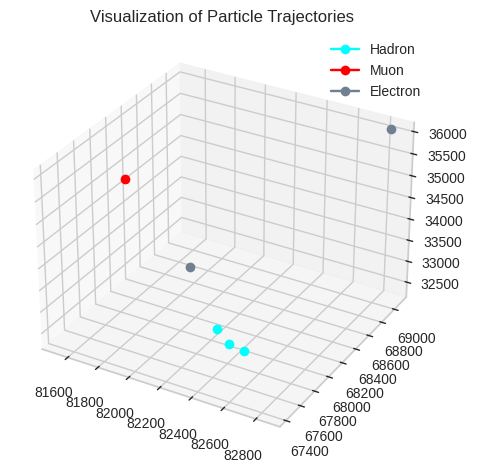

In [7]:
# Create a new figure and 3D axis
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

# Define colors and labels for each unique value of the trType column
colors = {
    1: ('red', 'Muon'), 
    2: ('aqua', 'Hadron'), 
    3: ('slategray', 'Electron'), 
    4: ('green', 'Black'), 
    5: ('gold', 'Back Black'), 
    6: ('teal', 'Gray'), 
    7: ('purple', 'Back Gray')
}  

# To ensure we add the labels only once
plotted_labels = set()

# Plot particle trajectories
for index, row in df_event.iterrows():
    x, y, z = row['posX'], row['posY'], row['posZ']
    trType = row['trType']
    
    # Check if trType is present in the colors dictionary
    if trType in colors:
        color, label = colors[trType]
        if label not in plotted_labels:
            ax.plot([x], [y], [z], marker='o', color=color, label=label)  # Add label
            plotted_labels.add(label)
        else:
            ax.plot([x], [y], [z], marker='o', color=color)
    else:
        ax.plot([x], [y], [z], marker='o')  # Use default color if trType is not in the dictionary

# Add title to the plot
ax.set_title('Visualization of Particle Trajectories')

# Add legend to the plot
ax.legend()

plt.show()

Each color represents a specific particle type in graphical representation:

- **Red**: Represents the "Muon" particle type.
- **Aqua**: Represents the "Hadron" particle type.
- **Slategray**: Represents the "Electron" particle type.
- **Green**: Represents the "Black" particle type.
- **Gold**: Represents the "Back Black" particle type.
- **Teal**: Represents the "Gray" particle type.
- **Purple**: Represents the "Back Gray" particle type.

### Loading vertex data

In [8]:
# List to store the DataFrames of each event
dataframes_events_vertex = {}

for file in os.listdir(directory):
    if file.endswith('_Vertex.csv'):
        # Extrair o nome do evento a partir do título do arquivo
        event_name = file.split('_Vertex.csv')[0]
        # Ler o arquivo CSV do vértice e adicionar ao dicionário de vértices
        file_path = os.path.join(directory, file)
        df_vertex = pd.read_csv(file_path)
        dataframes_events_vertex[event_name] = df_vertex
        
# Concatenate all event DataFrames into a single DataFrame
events_vertex = pd.concat(dataframes_events_vertex, ignore_index=True)

In [9]:
events_vertex

,evID,timestamp,posX,posY,posZ,globPosX,globPosY,globPosZ,mult
0,11154016262,1307080378000,33070.6,14223.8,17153.0,234.58600,-127.5360,-715.777,7
1,11275045692,1317581504000,116350.0,16557.3,38531.0,-193.36400,-211.3450,341.135,7
2,11201017638,1311144570000,73286.2,15147.2,40374.0,264.58200,-64.0793,475.319,2
3,11126002490,1304637352000,37357.0,23881.3,35313.0,145.78000,136.6300,528.413,2
4,10222036374,1281451782000,107511.0,73209.7,51724.5,178.06400,15.2170,-618.520,1
...,...,...,...,...,...,...,...,...,...
812,11212009338,1312080178000,73793.1,68508.9,29577.0,-133.85800,-216.8800,-620.734,6
813,12140038214,1337429934000,21755.6,71352.8,58298.0,169.53700,225.6100,-684.862,3
814,11081047000,1300833616000,76579.8,25255.6,18885.3,252.08600,220.9440,-568.204,2
815,12146034984,1337952666000,62245.8,88768.1,64894.0,-7.32032,100.9770,-523.403,3


### Selecting the Event ID

In [10]:
# Convert event_number to integer
event_number = int(event_number)

In [11]:
# Select the row where the 'evID' column is equal to the value of event_number
event_vertex = events_vertex.loc[events_vertex['evID'] == event_number]

# Display the selected row
print(event_vertex)

            evID      timestamp     posX     posY     posZ  globPosX  \
765  10140111072  1274374362000  82336.8  67912.8  31438.0  -17.5513   

     globPosY  globPosZ  mult  
765  -59.0607   420.826     6  


### Visualizing vertex

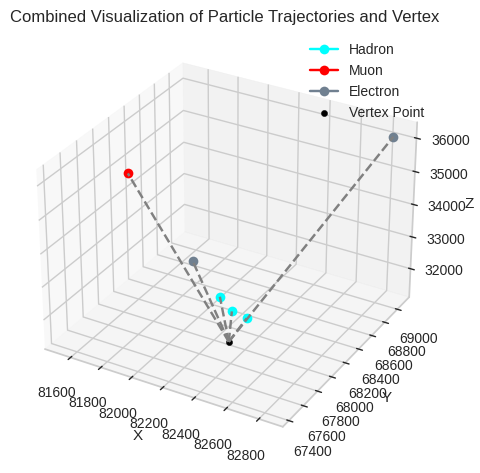

In [12]:
# Create a new figure and 3D axis
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

# Define colors and labels for each unique value of the trType column
colors = {
    1: ('red', 'Muon'), 
    2: ('aqua', 'Hadron'), 
    3: ('slategray', 'Electron'), 
    4: ('green', 'Black'), 
    5: ('gold', 'Back Black'), 
    6: ('teal', 'Gray'), 
    7: ('purple', 'Back Gray')
}  

# To ensure we add the labels only once
plotted_labels = set()

# Plot particle trajectories
for index, row in df_event.iterrows():
    x, y, z = row['posX'], row['posY'], row['posZ']
    trType = row['trType']
    
    # Check if trType is present in the colors dictionary
    if trType in colors:
        color, label = colors[trType]
        if label not in plotted_labels:
            ax.plot([x], [y], [z], marker='o', color=color, label=label)  # Add label
            plotted_labels.add(label)
        else:
            ax.plot([x], [y], [z], marker='o', color=color)
    else:
        ax.plot([x], [y], [z], marker='o')  # Use default color if trType is not in the dictionary

    # Add dashed gray line connecting vertex to track
    if not event_vertex.empty:
        x_vertex, y_vertex, z_vertex = event_vertex.iloc[0][['posX', 'posY', 'posZ']]
        ax.plot([x_vertex, x], [y_vertex, y], [z_vertex, z], linestyle='--', color='gray')

# Plot vertex point
if not event_vertex.empty:
    x_vertex, y_vertex, z_vertex = event_vertex.iloc[0][['posX', 'posY', 'posZ']]
    ax.scatter(x_vertex, y_vertex, z_vertex, marker='o', color='black', label='Vertex Point')

ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_zlabel('Z')

# Add title to the plot
ax.set_title('Combined Visualization of Particle Trajectories and Vertex')

# Add legend to the plot
ax.legend()

plt.show()

Each color represents a specific particle type in graphical representation:

- **Red**: Represents the "Muon" particle type.
- **Aqua**: Represents the "Hadron" particle type.
- **Slategray**: Represents the "Electron" particle type.
- **Green**: Represents the "Black" particle type.
- **Gold**: Represents the "Back Black" particle type.
- **Teal**: Represents the "Gray" particle type.
- **Purple**: Represents the "Back Gray" particle type.

### Muon Identification

Using machine learning classification techniques for muon identification based on track properties.

### Pre-processing

In [13]:
events

,trType,posX,posY,posZ,slopeXZ,slopeYZ
0,2,11889.9,61479.9,42595.0,0.0578,-0.0217
1,1,11662.8,61623.4,37391.0,0.1232,0.0187
2,2,11434.2,61727.6,38679.0,-0.0790,0.0627
3,2,11689.6,62020.4,38679.0,0.0502,0.2173
4,2,11622.6,61757.4,37391.0,0.0613,0.2266
...,...,...,...,...,...,...
3292,4,86183.1,35075.6,72285.0,0.1680,-0.2197
3293,6,86077.6,35154.8,72285.0,0.1638,-0.3143
3294,2,3425.6,29040.6,49146.0,0.4070,0.1144
3295,1,3394.1,29052.2,49146.0,0.0379,0.2370


The identification of null values indicates potential gaps or inconsistencies in the data, which can undermine the reliability of analyses and models built upon them. Furthermore, analyzing null data helps uncover biases that could distort statistical results or predictions in machine learning models. Properly managing null data through techniques such as imputation or removal of records with missing data is essential to ensure that data-driven decisions are accurate and dependable, thereby avoiding erroneous interpretations that could compromise critical outcomes and decisions.

In [14]:
# Analyzing null data
events.isna().any() 

trType     False
posX       False
posY       False
posZ       False
slopeXZ    False
slopeYZ    False
dtype: bool

Considering that one of the objectives is to develop a machine learning model that classifies muons `(trType = 1)` , we will use the trType column from the track data. Therefore, it is important to evaluate the distribution of variables in the trType column as it provides crucial insights into the balance or imbalance among different classes within the dataset. This analysis helps identify potential biases that may impact model performance, especially in scenarios where certain classes are underrepresented or overrepresented.

In [15]:
# Analyzing the original distribution 
events['trType'].value_counts(normalize=True)

trType
2    0.472551
1    0.248104
4    0.096148
3    0.084926
6    0.054595
5    0.039733
7    0.003943
Name: proportion, dtype: float64

### Turn the problem into a binary problem  (one vs all)

The classifier's goal is to identify which particles are muons, making it pertinent to transform the problem into a binary classification.

In [16]:
events['trType'] = events['trType'].apply(lambda x: 1 if x == 1 else 0)

# Analyzing the new distribution 
events['trType'].value_counts(normalize=True)

trType
0    0.751896
1    0.248104
Name: proportion, dtype: float64

Analyzing the new distribution is crucial because it provides insights into the proportion of muons (1s) versus non-muons (0s) in the dataset. This step helps in understanding the class distribution imbalance, which is fundamental for training a binary classifier effectively. It guides decisions on handling imbalanced data and selecting appropriate evaluation metrics tailored to the specific class distribution, ensuring the classifier's accuracy and reliability in distinguishing muons from other particles.

In [17]:
# Print the percentage of 'No muon' class in the dataset
print('No muon', round(events['trType'].value_counts()[0]/len(events) * 100, 2), '% of the dataset')

# Print the percentage of 'Muon' class in the dataset
print('Muon', round(events['trType'].value_counts()[1]/len(events) * 100, 2), '% of the dataset')

No muon 75.19 % of the dataset
Muon 24.81 % of the dataset


Text(0.5, 1.0, 'trType Distributions \n (0: No Muon || 1: Muon)')

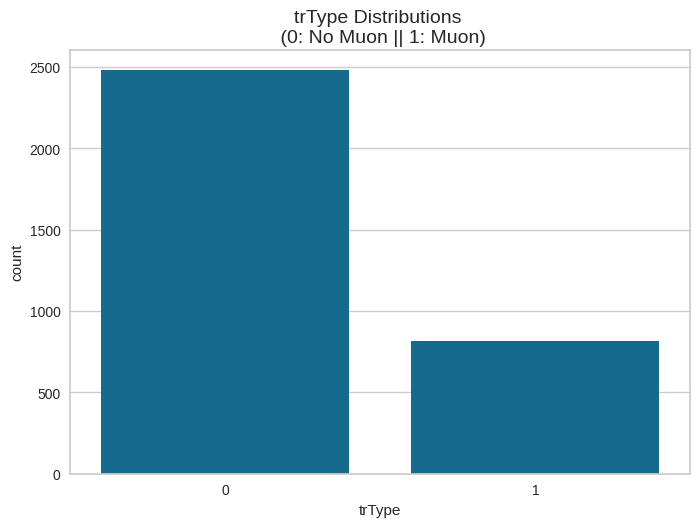

In [18]:
# Plot a count plot of 'trType' column from the 'events' DataFrame using seaborn
sns.countplot(x='trType', data=events)

# Set the title of the plot
plt.title('trType Distributions \n (0: No Muon || 1: Muon)', fontsize=14)

This reveals a class imbalance, with 75.19% of the data belonging to the "No muon" class and 24.81% to the "Muon" class, as depicted graphically above. This significant disparity in class distribution can affect the machine learning model's ability to learn balanced and accurate representations of both classes during training.

### Check the linear separability between variables

This step is crucial in choosing the appropriate machine learning model because for linear models such as linear regression and linear classifiers (like logistic regression and linear SVM), the linear separability between variables significantly influences the model's suitability, performance, and interpretability. Linear models assume that data can be separated by a line or hyperplane, and they may exhibit suboptimal performance or overfitting if this assumption is not met. On the other hand, nonlinear models such as decision trees and neural networks do not rely on this linear separability, allowing them to handle more complex relationships among input variables.

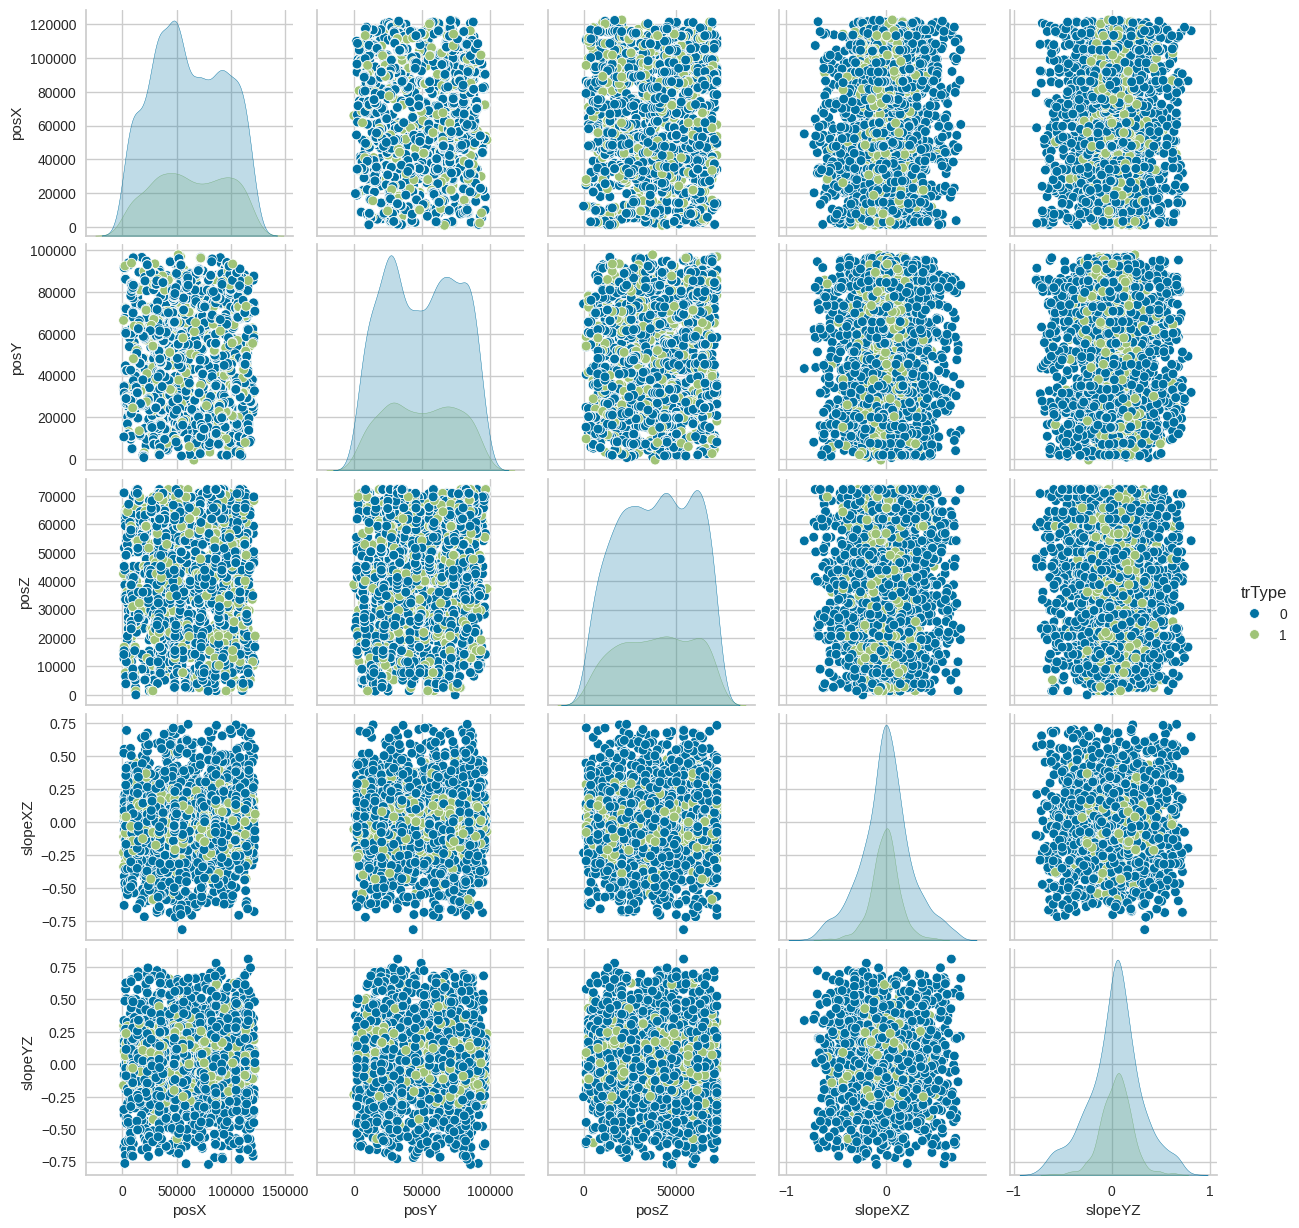

In [19]:
# Visual analysis of the existence of linear separability
sns.pairplot(events, hue='trType')

Apparently, none of the 2 x 2 combinations show linear separability, indicating that nonlinear models might achieve better results.

### Checking the dynamic range of the data

Checking the data dynamic range involves examining the amplitude or variation of values within a dataset. This is crucial before training a machine learning model because the scale of the data can directly impact the model's performance and effectiveness. Machine learning models can be sensitive to the scale of input data. If the data exhibits high variability or a wide dynamic range, some models may struggle to learn meaningful patterns or may converge more slowly during training.

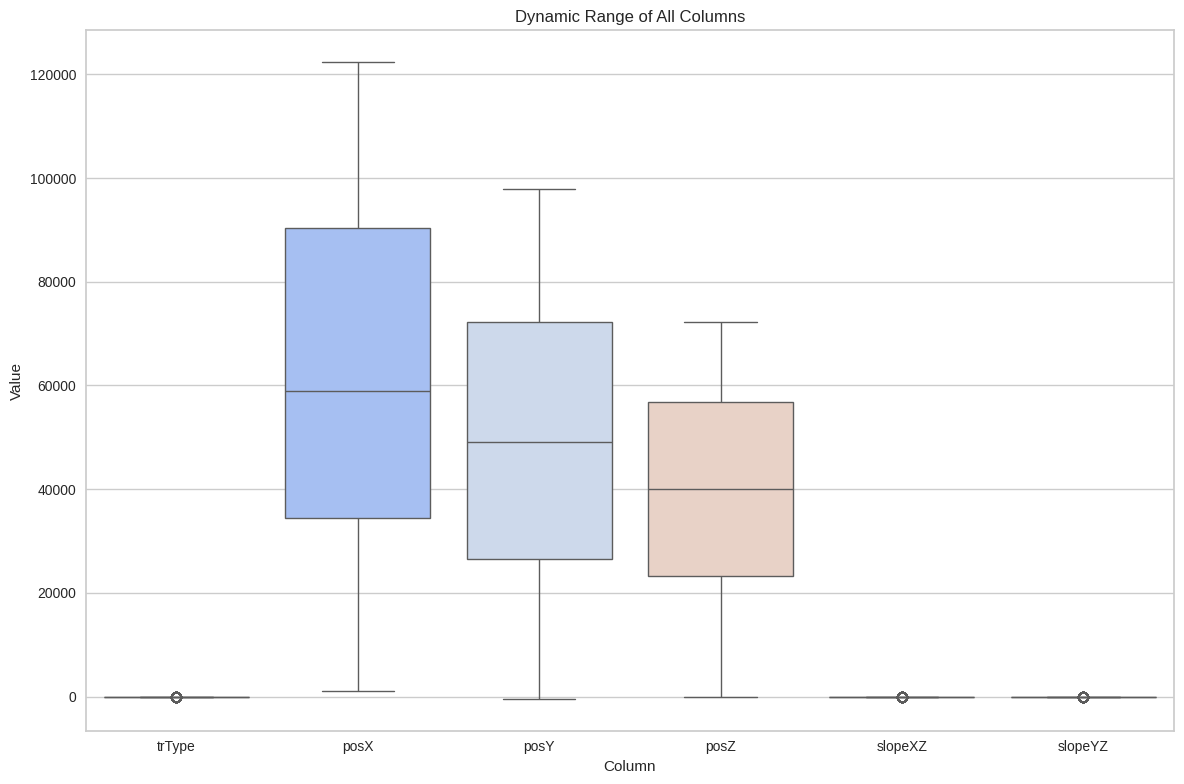

In [20]:
# Create a figure with specified size
plt.figure(figsize=(12, 8))

# Creates a boxplot for each numerical column in the events DataFrame. 
#Boxplots are used here to visualize the distribution of data, including the median, quartiles, and any outliers that may exist.
sns.boxplot(data=events, width=0.8, palette="coolwarm")

# Label the x-axis
plt.xlabel('Column')

# Label the y-axis
plt.ylabel('Value')

# Set the title of the plot
plt.title('Dynamic Range of All Columns')

# Ensure the plot layout is tight
plt.tight_layout()

# Display the plot
plt.show()

Upon examining the box plots side by side, it becomes evident that the central position (median), dispersion (box size), and data ranges (whiskers) are notably different. This discrepancy indicates that the data is not within the same dynamic range. To address this issue, the MinMax scaler will be used to scale the data into the same dynamic range. The MinMax scaler transforms the data such that all features are scaled to a given range (e.g., between 0 and 1). This scaling ensures that each feature contributes equally to the analysis and prevents features with larger scales from dominating the learning algorithm. Thus, applying the MinMax scaler helps to standardize the data and improve the consistency and performance of machine learning models.

In [21]:
# Select numeric columns from the 'events' DataFrame
events_numeric = events.select_dtypes(include='number')

# Initialize MinMaxScaler object
scaler = MinMaxScaler()

# Scale the numeric data using MinMaxScaler
events_scaled_array = scaler.fit_transform(events_numeric)

# Create a new DataFrame 'events_scaled' with scaled values,
# using original column names and index from 'events_numeric'
events_scaled = pd.DataFrame(events_scaled_array, columns=events_numeric.columns, index=events_numeric.index)

In [22]:
events_scaled

,trType,posX,posY,posZ,slopeXZ,slopeYZ
0,0.0,0.089074,0.629483,0.589611,0.561862,0.474363
1,1.0,0.087201,0.630941,0.517679,0.603852,0.499905
2,0.0,0.085316,0.632001,0.535482,0.474029,0.527723
3,0.0,0.087422,0.634977,0.535482,0.556982,0.625466
4,0.0,0.086869,0.632304,0.517679,0.564109,0.631346
...,...,...,...,...,...,...
3292,0.0,0.701744,0.361078,1.000000,0.632616,0.349181
3293,0.0,0.700874,0.361883,1.000000,0.629920,0.289372
3294,0.0,0.019272,0.299731,0.680162,0.786067,0.560410
3295,1.0,0.019012,0.299849,0.680162,0.549085,0.637921


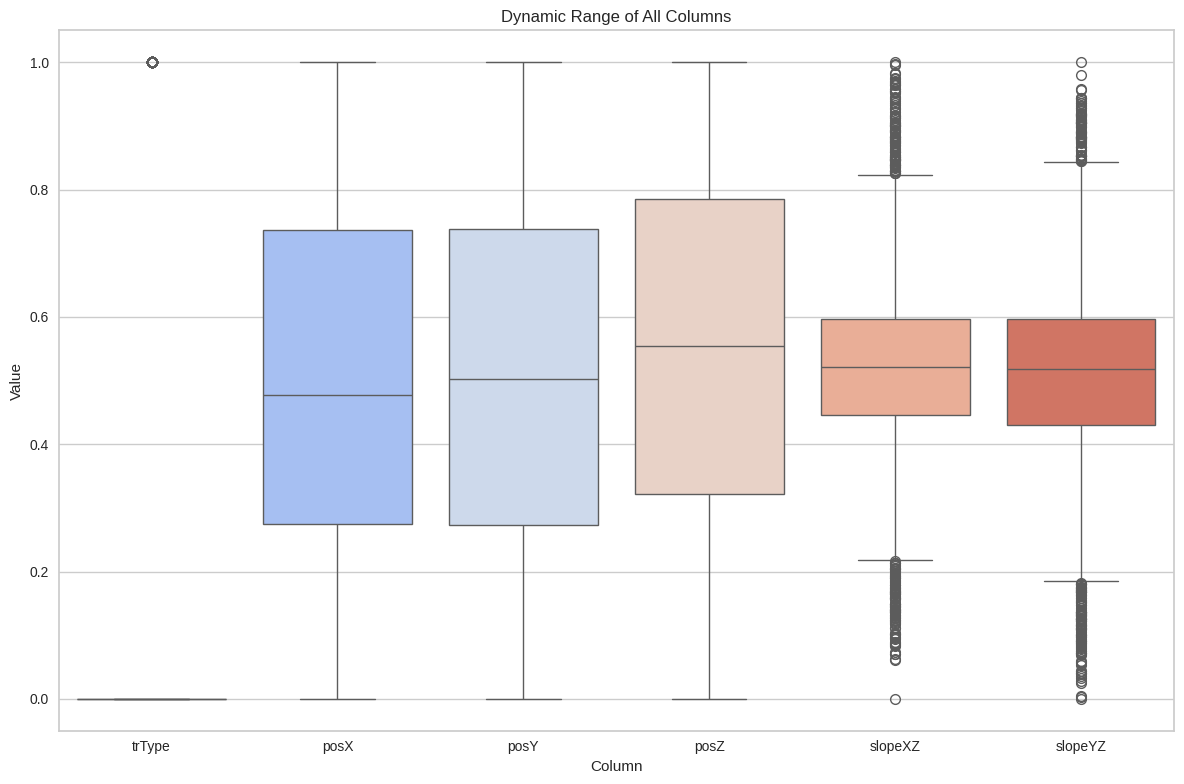

In [23]:
# Create a figure with specified size
plt.figure(figsize=(12, 8))

# Create a boxplot of all columns in the 'events_scaled' DataFrame
# Boxplots are effective for visualizing the range, distribution, and outliers of numerical data
sns.boxplot(data=events_scaled, width=0.8, palette="coolwarm")

# Label the x-axis
plt.xlabel('Column')

# Label the y-axis
plt.ylabel('Value')

# Set the title of the plot
plt.title('Dynamic Range of All Columns')

# Ensure the plot layout is tight
plt.tight_layout()

# Display the plot
plt.show()

Therefore, it is verified that the data is now in the same dynamic range.

### Separating training and testing - with stratification to deal with unbalanced classes

For machine learning models, it is crucial to split the dataset into two distinct sets: training and testing. The training set is used to train the model, exposing it to data to learn patterns and relationships between variables. Conversely, the testing set is reserved to evaluate the model's performance on unseen data, simulating how the model will behave in practice with new data. This separation is critical to ensure the model is assessed impartially and can generalize well to data not used in training.

When the dataset is imbalanced, meaning there is a significant disparity in the number of examples between classes, it is important to perform the train-test split with stratification. Stratification preserves the class proportions in both sets, ensuring they accurately represent the class distribution in the original dataset. This is essential because machine learning models may struggle to learn minority classes correctly if they are not exposed to sufficient examples during training.

In [24]:
# Separating x and y
x = events_scaled.drop(columns=['trType'])
y = events_scaled[['trType']]

In [25]:
# Separating training and testing - with stratification to deal with unbalanced classes
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.3, stratify=y)

# Analyzing proportions - again
props = pd.DataFrame(y.value_counts(normalize=True), columns=['Original'])
props['train'] = y_train.value_counts(normalize=True).values
props['test'] = y_test.value_counts(normalize=True).values
props

,Original,train,test
0,NaN,0.752059,0.751515
1,NaN,0.247941,0.248485


When dealing with imbalanced classes in machine learning problems, the SMOTE (Synthetic Minority Over-sampling Technique) method becomes a valuable tool. SMOTE is an oversampling technique that generates synthetic examples of the minority class based on existing examples, aiming to balance the distribution of classes in the dataset. This technique creates synthetic instances by calculating nearest neighbors for each example in the minority class and generating new examples along the line connecting these neighbors. The importance of SMOTE lies in its ability to train the machine learning model with a more balanced dataset. However, it is important to note that even when using SMOTE, the model may still face challenges because the synthetic data created may not capture all the nuances of the real data, which can affect the model's ability to generalize to unseen data during training.

In [26]:
# Instantiate SMOTE with a specified random state for reproducibility
smote = SMOTE(random_state=0)

# Apply SMOTE to the training set to oversample the minority class
x_train, y_train = smote.fit_resample(x_train, y_train)

# Apply SMOTE to the test set to oversample the minority class (Note: This is generally not recommended; should use original test set)
x_test, y_test = smote.fit_resample(x_test, y_test)

In [27]:
# Analyzing proportions - again
props_ = pd.DataFrame(y.value_counts(normalize=True), columns=['Original'])
props_['train'] = y_train.value_counts(normalize=True).values
props_['test'] = y_test.value_counts(normalize=True).values
props_

,Original,train,test
0,NaN,0.5,0.5
1,NaN,0.5,0.5


### Finding the best model

The PyCaret will be used, which implements an efficient model selection process where a variety of machine learning models are quickly trained and compared based on the specified metric. Initially, the PyCaret environment is initialized with the provided data and settings. Then, for each selected model, PyCaret performs rapid training using techniques such as cross-validation and hyperparameter tuning to evaluate the model's performance against the chosen metric. After training all selected models, PyCaret compares their performance and selects the model with the best performance, which is returned as the "best model".

When classes are unbalanced it is useful to use the F1 score metric, which balances accuracy and recall. Furthermore, accuracy is not the best metric for imbalanced class cases because it can be misleading, predominantly reflecting the majority class and ignoring the importance of the minority class. A model can achieve high accuracy simply by predicting the majority class, even if it completely fails to identify the minority class.

In [28]:
# Initialize the PyCaret environment
clf1 = setup(events, target='trType', session_id=123)

# Compare models using F1 Score as ranking metric
best_model = compare_models(sort='F1')

# Display the best model
print(best_model)

,Description,Value
0,Session id,123
1,Target,trType
2,Target type,Binary
3,Original data shape,"(3297, 6)"
4,Transformed data shape,"(3297, 6)"
5,Transformed train set shape,"(2307, 6)"
6,Transformed test set shape,"(990, 6)"
7,Numeric features,5
8,Preprocess,True
9,Imputation type,simple


,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC,TT (Sec)
dt,Decision Tree Classifier,0.6601,0.5403,0.3025,0.3126,0.3053,0.0817,0.0823,0.0240
xgboost,Extreme Gradient Boosting,0.7113,0.6349,0.2132,0.3640,0.2657,0.1022,0.1090,0.0810
lightgbm,Light Gradient Boosting Machine,0.7135,0.6297,0.1556,0.3308,0.2077,0.0631,0.0699,25.0390
qda,Quadratic Discriminant Analysis,0.7390,0.6770,0.0857,0.3944,0.1390,0.0543,0.0780,0.0180
rf,Random Forest Classifier,0.7304,0.6492,0.0857,0.3316,0.1311,0.0369,0.0491,0.2960
catboost,CatBoost Classifier,0.7404,0.6641,0.0613,0.3670,0.1029,0.0349,0.0547,2.2130
et,Extra Trees Classifier,0.7256,0.6386,0.0560,0.2350,0.0896,0.0031,0.0013,0.1810
svm,SVM - Linear Kernel,0.7395,0.4848,0.0438,0.2392,0.0548,0.0146,0.0244,0.0230
knn,K Neighbors Classifier,0.7161,0.3956,0.0297,0.1490,0.0482,-0.0380,-0.0542,0.0290
gbc,Gradient Boosting Classifier,0.7438,0.6491,0.0210,0.2167,0.0382,0.0044,0.0025,0.2550


DecisionTreeClassifier(ccp_alpha=0.0, class_weight=None, criterion='gini',
                       max_depth=None, max_features=None, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_samples_leaf=1,
                       min_samples_split=2, min_weight_fraction_leaf=0.0,
                       monotonic_cst=None, random_state=123, splitter='best')


Given that the variables do not show linear separability and the decision tree model achieved the best F1-score, it will be used in this case, which is feasible considering the relatively small size of the dataset. However, if the dataset were extensive, it would be more appropriate to employ the binary decision tree model, which is less computationally costly. In a binary decision tree, each node divides the data into exactly two branches based on binary conditions (yes/no). In contrast, in a traditional decision tree, each node can divide the data into more than two branches, allowing decisions based on multiple categories or conditions in a single step. Therefore, due to the small size of the dataset, the decision tree is computationally feasible, allowing the number of nodes to be determined during model training.

### Training the tree decision model

The decision tree model works by dividing the dataset into smaller subsets based on specific features, until the leaves of the tree represent classes or output values. This tree can be used to classify new data (in classification problems) or make predictions (in regression problems). During classification or prediction, new data follows the paths of the tree based on their features until reaching a leaf, where the corresponding class or value is assigned.

#### The tree construction follows a step-by-step process:

1. Data Splitting: Initially, all data resides in the root node of the tree. The tree begins to take shape as the algorithm evaluates attributes and selects the one that best divides the data into more homogeneous subsets, initiating its growth.

2. Tree Growth: After the attribute selection, data is divided into subsets based on their values. This process iterates, branching the tree until stopping criteria are met, such as reaching the maximum depth of the tree, having a minimum number of samples in a leaf node, or when there is no further significant gain in homogeneity. Each split is like a new bud extending from the main tree.

3. Pruning: Once the tree has reached its full form, pruning comes into play to refine it and prevent overfitting. Parts of the tree that do not significantly contribute to its generalization ability are removed, leaving behind a leaner and more effective structure. Thus, the tree grows continuously but is refined to maintain its relevance and accuracy.

Hyperparameter search is performed by BayesSearchCV, which tests different combinations of parameters defined in the param_space to find the configuration that maximizes the f1 metric. The following types of distributions are used to define the search space for the model's hyperparameters:

- **criterion**: Split criterion for the decision tree, which can be 'gini' or 'entropy'. (Both criteria help determine the best split for a node, with the goal of creating the most homogeneous possible data subgroups.)
- **max_depth**: Maximum depth of the tree, ranging from 1 to 6.
- **min_samples_split**: Minimum number of samples required to split an internal node, ranging from 2 to 20.
- **min_samples_leaf**: Minimum number of samples required to be at a leaf node, ranging from 1 to 10.
- **max_features**: Number of features to consider for the best split, which can be 'sqrt', 'log2', or None.
- **class_weight**: Class weights, which can be None or 'balanced'.

The Bayesian hyperparameter search (BayesSearchCV) is applied using cross-validation. In cross-validation, the dataset is split into multiple folds, where the model is trained on several of these folds and evaluated on the remaining fold. This process is repeated multiple times, ensuring that each fold is used both for training and validation across different iterations. Different combinations from the hyperparameter search space are then assessed through cross-validation, using the F1 score metric as the evaluation criterion. This approach provides a more precise selection of optimal parameters to optimize the model, enhancing its effectiveness in finding configurations that best fit the data. Moreover, it increases the reliability of conclusions regarding the model's performance on unseen datasets.

In [29]:
# Creating the classifier
dt = DecisionTreeClassifier(random_state=42)

# Defining the search space for hyperparameters
param_space = {
    'criterion': Categorical(['gini', 'entropy']),  # Split criterion for decision tree
    'max_depth': Integer(1, 6),                     # Maximum depth of the tree
    'min_samples_split': Integer(2, 20),            # Minimum samples required to split an internal node
    'min_samples_leaf': Integer(1, 10),             # Minimum samples required to be at a leaf node
    'max_features': Categorical(['sqrt', 'log2', None]),  # Maximum number of features to consider for splitting
    'class_weight': Categorical([None, 'balanced'])  # Weight adjustment for class imbalance
}

# Setting up the cross-validation splitter
splitter = StratifiedKFold(n_splits=10, shuffle=True, random_state=2)

# Setting up the Bayesian search
bayes_search = BayesSearchCV(
    estimator=dt,
    search_spaces=param_space,
    n_iter=100,             # Number of iterations for Bayesian search
    cv=splitter,
    refit=True,
    scoring='f1',           # Scoring metric to optimize
    error_score=0,
    verbose=0,
    random_state=2
)

# Fitting the Bayesian search to the data
bayes_search.fit(x_train, y_train)

# Printing the best found hyperparameters
print("Best Hyperparameters:", bayes_search.best_params_)

Best Hyperparameters: OrderedDict([('class_weight', 'balanced'), ('criterion', 'entropy'), ('max_depth', 3), ('max_features', None), ('min_samples_leaf', 2), ('min_samples_split', 19)])


Assessing feature importance is crucial in machine learning model development as it allows identifying which input variables have the greatest influence on the model's predictions. This process not only aids in interpreting the model's decision-making but also streamlines feature selection, particularly in high-dimensional models. Moreover, this analysis can lead to cost savings by prioritizing the collection of more relevant data for accurate model predictions.

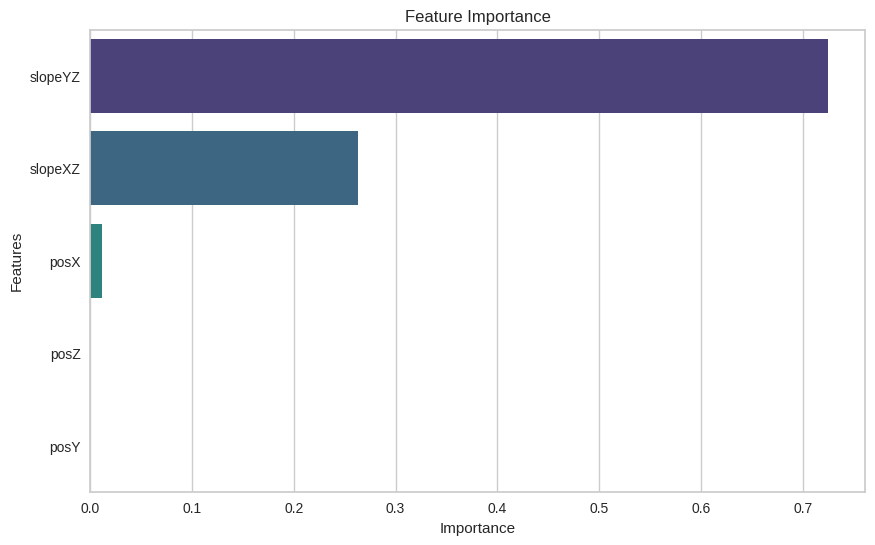

In [30]:
# Get the best estimator from the Bayesian search
best_model = bayes_search.best_estimator_

# Retrieve the feature importances from the best model
feature_importances = best_model.feature_importances_

# Real names of the features
feature_names = x_train.columns

# Sort the features by their importance in descending order
indices = np.argsort(feature_importances)[::-1]

# Plot the feature importances
plt.figure(figsize=(10, 6))
sns.barplot(x=feature_importances[indices], y=np.array(feature_names)[indices], palette="viridis")
plt.title('Feature Importance')
plt.xlabel('Importance')
plt.ylabel('Features')
plt.show()

The feature importance plot reveals that the most relevant characteristic for the model to decide whether the particle is a muon or not is Slope YZ.

In [31]:
# Getting the best hyperparameters found

best_params = bayes_search.best_params_
best_estimator = bayes_search.best_estimator_

In [32]:
# Analyzing the final performance
# Making new predictions
yhat_train = bayes_search.best_estimator_.predict(x_train)
yhat_test = bayes_search.best_estimator_.predict(x_test)


# Analyzing the performance
print('Performance - Training Set')
print(classification_report(y_train, yhat_train))

print('Performance - Test Set')
print(classification_report(y_test, yhat_test))

Performance - Training Set
              precision    recall  f1-score   support

         0.0       0.82      0.42      0.55      1735
         1.0       0.61      0.90      0.73      1735

    accuracy                           0.66      3470
   macro avg       0.71      0.66      0.64      3470
weighted avg       0.71      0.66      0.64      3470

Performance - Test Set
              precision    recall  f1-score   support

         0.0       0.78      0.43      0.55       744
         1.0       0.61      0.88      0.72       744

    accuracy                           0.65      1488
   macro avg       0.69      0.65      0.64      1488
weighted avg       0.69      0.65      0.64      1488



These results suggest that the model demonstrates a good ability to identify class 1 (Muon) with high recall and acceptable precision. However, its ability to correctly identify class 0 (Non Muon) is limited, as indicated by the lower recall and inferior F1-score.

In [33]:
# Getting the best probabilistic predictions for the test set
y_pred_prob = bayes_search.best_estimator_.predict_proba(x_test)[:, 1]


# Calculating the ROC curve
fpr, tpr, thresholds = roc_curve(y_test, y_pred_prob)

# Calculating Area Under Curve (AUC)
auc_score = auc(fpr, tpr)

print("AUC:", auc_score)

AUC: 0.6625422736732569


The AUC (Area Under the ROC Curve) value of 0.662 indicates that the model has a low ability to distinguish between the two classes.

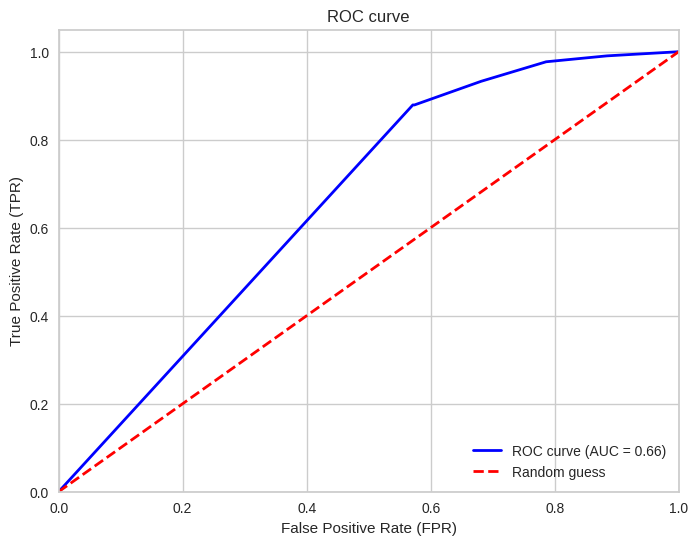

In [34]:
# Plotting the ROC curve
plt.figure(figsize=(8, 6))

# Plot the ROC curve with AUC score
plt.plot(fpr, tpr, color='blue', lw=2, label='ROC curve (AUC = %0.2f)' % auc_score)

# Plot the line of random guessing (baseline)
plt.plot([0, 1], [0, 1], color='red', lw=2, linestyle='--', label='Random guess')

# Set the limits and labels for the plot
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate (FPR)')
plt.ylabel('True Positive Rate (TPR)')
plt.title('ROC curve')
plt.legend(loc='lower right')
plt.show()

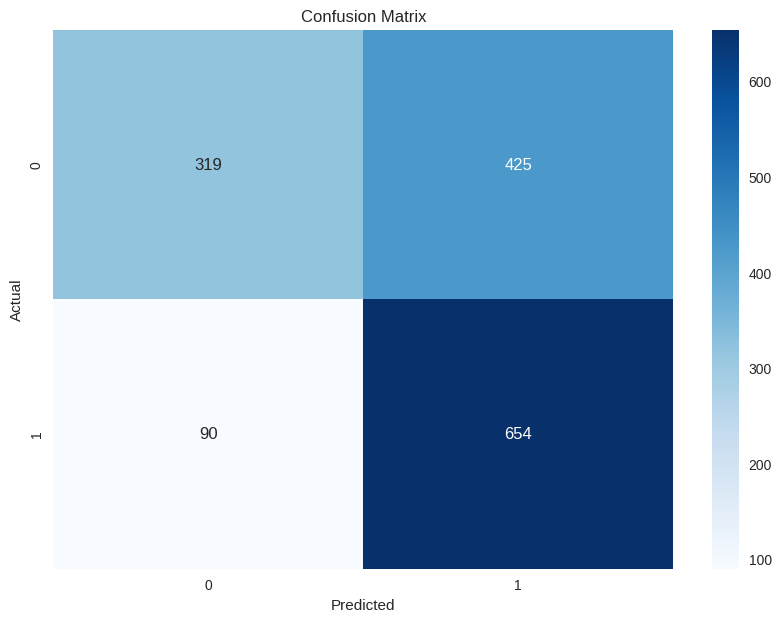

In [35]:
#  Make predictions in the test set
y_pred = bayes_search.predict(x_test)

# The matrix of confusion
cm = confusion_matrix(y_test, y_pred)

# Plotting the confusion matrix 
plt.figure(figsize=(10, 7))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

Considering that the goal of the model is to identify muons in the Opera detector data, it is important to minimize classification errors, especially false negatives, which can lead to the loss of important information by incorrectly classifying a muon as a non-muon.

In this context, the model demonstrated some success by achieving high recall and acceptable precision in identifying muons. However, the confusion matrix reveals that the model is not perfect: out of 744 muon events, 90 were misclassified as non-muons, resulting in an error rate of approximately 12.10%, highlighting limitations in classification accuracy.

Additionally, the model faces challenges in clearly distinguishing between classes, potentially misclassifying other particles as muons. This necessitates post-processing to address false positives—particles incorrectly identified as muons—though this does not necessarily lead to information loss.

Therefore, when considering the use of this model for muon classification, it is crucial to weigh the potential information loss due to its imperfections and the need for post-processing to mitigate false positives. The final decision on adopting the model will depend on the cost-benefit analysis of the required post-processing and the impact of any lost information.

### Training the Random Forest

The imbalanced classes in the data are a possible cause of the classification problems observed during the training of the decision tree model, even with the use of SMOTE. This happens because the synthetic data generated by SMOTE may not capture all the nuances of the real data, affecting the model's ability to generalize to new data during training. 

Therefore, the Random Forest model will also be trained, which is known to be more robust in cases of imbalanced classes. Since the dataset is not very extensive, the computational training of the Random Forest model is feasible. However, very large datasets may require long training periods.

Random Forest is an ensemble method that combines multiple independent decision trees, trained on random subsets of the data. Each decision tree is trained independently, which reduces overfitting compared to a single decision tree and helps mitigate bias that can occur in models sensitive to class imbalances.

Additionally, each decision tree is trained on a random subset of data that may contain examples from both the majority and minority classes. This helps capture the nuances of minority classes better without overestimating the majority class. 

Hyperparameter search is performed by BayesSearchCV, which tests different combinations of parameters defined in the hyperparameter_space to find the configuration that maximizes the f1 metric. The following types of distributions are used to define the search space for the model's hyperparameters:

- **n_estimators**: Number of trees in the forest, ranging from 50 to 500.
- **max_depth**: Maximum depth of each tree, ranging from 1 to 20.
- **min_samples_split**: Minimum number of samples required to split an internal node, ranging from 2 to 20.
- **min_samples_leaf**: Minimum number of samples that a leaf node must have, ranging from 1 to 10.
- **max_features**: Number of features to consider for the best split, which can be 'sqrt', 'log2', or None.
- **class_weight**: Class weights, which can be None, 'balanced', or 'balanced_subsample'.

The Bayesian hyperparameter search (BayesSearchCV) is applied using cross-validation. In cross-validation, the dataset is split into multiple folds, where the model is trained on several of these folds and evaluated on the remaining fold. This process is repeated multiple times, ensuring that each fold is used both for training and validation across different iterations. Different combinations from the hyperparameter search space are then assessed through cross-validation, using the F1 score metric as the evaluation criterion. This approach provides a more precise selection of optimal parameters to optimize the model, enhancing its effectiveness in finding configurations that best fit the data. Moreover, it increases the reliability of conclusions regarding the model's performance on unseen datasets.

In [36]:
# Creating the classifier
forest_classifier = RandomForestClassifier(random_state=42)

# Defining the search space for hyperparameters
hyperparameter_space = {
    'n_estimators': Integer(50, 500),
    'max_depth': Integer(1, 20),
    'min_samples_split': Integer(2, 20),
    'min_samples_leaf': Integer(1, 10),
    'max_features': Categorical(['sqrt', 'log2', None]),
    'class_weight': Categorical([None, 'balanced', 'balanced_subsample'])
}

# Setting up the cross-validation sampler
cross_validator = StratifiedKFold(n_splits=10, shuffle=True, random_state=2)

# Setting up the Bayesian search
bayesian_search = BayesSearchCV(
    estimator=forest_classifier,
    search_spaces=hyperparameter_space,
    n_iter=100,  # number of iterations for the Bayesian search
    cv=cross_validator,
    refit=True,
    scoring='f1',
    error_score=0,
    verbose=0,
    random_state=2
)

# Fitting the Bayesian search to the data
bayesian_search.fit(x_train, y_train)

# Printing the best hyperparameters found
print("Best Hyperparameters:", bayesian_search.best_params_)

Best Hyperparameters: OrderedDict([('class_weight', 'balanced'), ('max_depth', 20), ('max_features', 'log2'), ('min_samples_leaf', 1), ('min_samples_split', 2), ('n_estimators', 470)])


In [37]:
# Getting the best hyperparameters found
optimal_params = bayesian_search.best_params_
optimal_model = bayesian_search.best_estimator_

# Analyzing the final performance
# Making new predictions
train_predictions = optimal_model.predict(x_train)
test_predictions = optimal_model.predict(x_test)

# Analyzing the performance
print('Performance - Training Set')
print(classification_report(y_train, train_predictions))

print('Performance - Test Set')
print(classification_report(y_test, test_predictions))

Performance - Training Set
              precision    recall  f1-score   support

         0.0       1.00      0.99      0.99      1735
         1.0       0.99      1.00      0.99      1735

    accuracy                           0.99      3470
   macro avg       0.99      0.99      0.99      3470
weighted avg       0.99      0.99      0.99      3470

Performance - Test Set
              precision    recall  f1-score   support

         0.0       0.64      0.74      0.68       744
         1.0       0.69      0.58      0.63       744

    accuracy                           0.66      1488
   macro avg       0.66      0.66      0.66      1488
weighted avg       0.66      0.66      0.66      1488



The model exhibits a notable decrease in precision, recall, and F1-score on the test set compared to the training set, suggesting overfitting and highlighting the need for improvement, particularly in enhancing recall for class 1. 

In [38]:
# Getting the best probabilistic predictions for the test set
test_prob_predictions = bayesian_search.best_estimator_.predict_proba(x_test)[:, 1]

# Calculating the ROC curve
false_positive_rate, true_positive_rate, roc_thresholds = roc_curve(y_test, test_prob_predictions)

# Calculating Area Under Curve (AUC)
roc_auc_rf = auc(false_positive_rate, true_positive_rate)

print("AUC:", roc_auc_rf)

AUC: 0.7365004263498669


A value of AUC (Area Under the Curve) of 0.736 indicates that the model performs reasonably well in classification, suggesting it is not making random classifications.

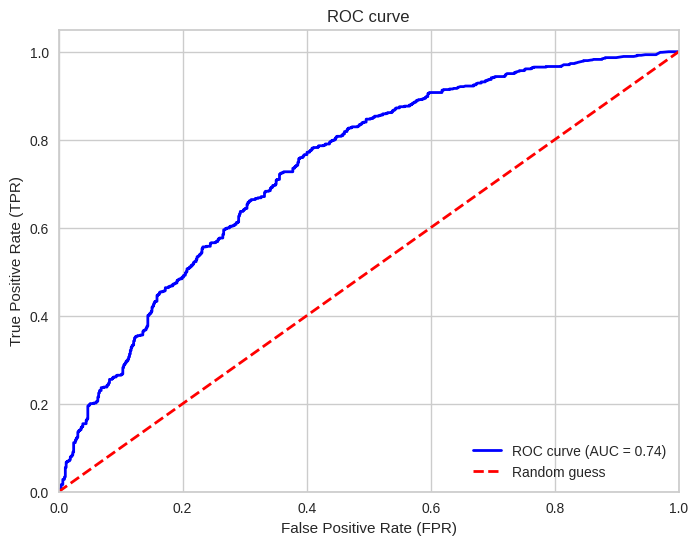

In [39]:
# Plotting the ROC curve
plt.figure(figsize=(8, 6))
plt.plot(false_positive_rate, true_positive_rate, color='blue', lw=2, label='ROC curve (AUC = %0.2f)' % roc_auc_rf)
plt.plot([0, 1], [0, 1], color='red', lw=2, linestyle='--', label='Random guess')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate (FPR)')
plt.ylabel('True Positive Rate (TPR)')
plt.title('ROC curve')
plt.legend(loc='lower right')
plt.show()

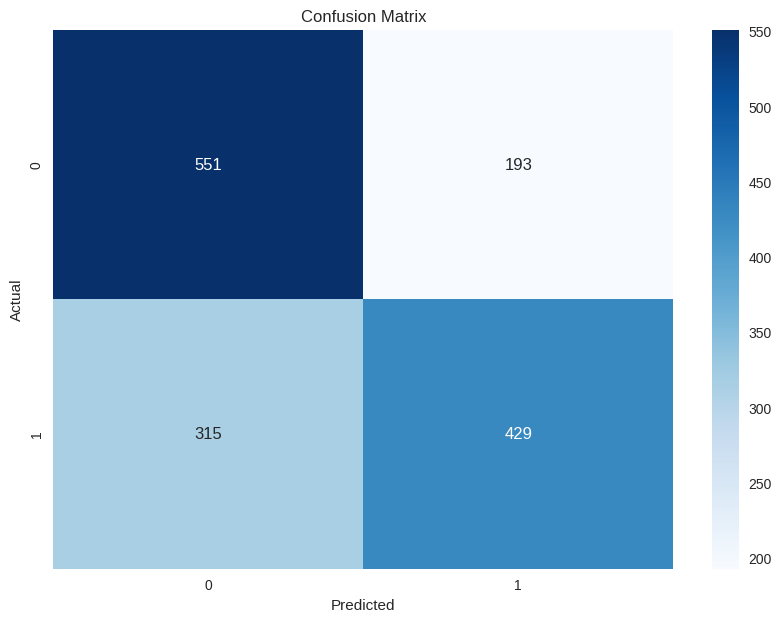

In [40]:
# Make predictions on the test set
test_predictions = bayesian_search.predict(x_test)

# Confusion matrix
confusion_rf = confusion_matrix(y_test, test_predictions)

# Plotting the confusion matrix using seaborn for a nicer visualization
plt.figure(figsize=(10, 7))
sns.heatmap(confusion_rf, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

The confusion matrix result reveals that the model is showing reasonable performance in distinguishing between classes 0 and 1. However, considering that the classifier's objective is to identify muons, the information loss when a muon is incorrectly classified as non-muon is significant, highlighting the need for model improvement.

### Training the Decision Tree + Random Forest

#### Considering that decision tree and random forest models have distinct advantages, an ensemble combining both models will be trained.

The code initializes an ensemble learning approach using a VotingClassifier, which combines individual RandomForestClassifier and DecisionTreeClassifier models. Each model is initialized with specific hyperparameter search spaces defined to optimize their performance.

For the RandomForestClassifier, the search space includes parameters such as:
- **n_estimators**: Number of trees in the forest, ranging from 50 to 500.
- **max_depth**: Maximum depth of trees, ranging from 1 to 20.
- **min_samples_split**: Minimum number of samples required to split an internal node, ranging from 2 to 20.
- **min_samples_leaf**: Minimum number of samples required to be at a leaf node, ranging from 1 to 10.
- **max_features**: Number of features to consider for the best split, options are 'sqrt', 'log2', or None.
- **class_weight**: Class weight options, including None, 'balanced', or 'balanced_subsample'.

Similarly, for the DecisionTreeClassifier, the search space defines parameters such as:
- **criterion**: Criterion for splitting, either 'gini' or 'entropy'.
- **max_depth**: Maximum depth of the decision tree, ranging from 1 to 6.
- **min_samples_split**: Minimum number of samples required to split an internal node, ranging from 2 to 20.
- **min_samples_leaf**: Minimum number of samples required to be at a leaf node, ranging from 1 to 10.
- **max_features**: Number of features to consider for the best split, options are 'sqrt', 'log2', or None.
- **class_weight**: Class weight options, including None or 'balanced'.

These search spaces are combined into a unified hyperparameter search space, which is explored using Bayesian optimization (BayesSearchCV). Bayesian optimization efficiently searches for the optimal combination of hyperparameters by iteratively proposing parameter settings based on the outcomes of previous evaluations. 

The Bayesian hyperparameter search (BayesSearchCV) is applied using cross-validation. In cross-validation, the dataset is split into multiple folds, where the model is trained on several of these folds and evaluated on the remaining fold. This process is repeated multiple times, ensuring that each fold is used both for training and validation across different iterations. Different combinations from the hyperparameter search space are then assessed through cross-validation, using the F1 score metric as the evaluation criterion. This approach provides a more precise selection of optimal parameters to optimize the model, enhancing its effectiveness in finding configurations that best fit the data. Moreover, it increases the reliability of conclusions regarding the model's performance on unseen datasets.

In [41]:
# Creating individual classifiers
random_forest_classifier = RandomForestClassifier(random_state=42)
decision_tree_classifier = DecisionTreeClassifier(random_state=42)

# Creating the ensemble
voting_ensemble = VotingClassifier(estimators=[('rf', random_forest_classifier), ('dt', decision_tree_classifier)], voting='soft')

# Defining the search space for RandomForestClassifier hyperparameters
random_forest_search_space = {
    'rf__n_estimators': Integer(50, 500),
    'rf__max_depth': Integer(1, 20),
    'rf__min_samples_split': Integer(2, 20),
    'rf__min_samples_leaf': Integer(1, 10),
    'rf__max_features': Categorical(['sqrt', 'log2', None]),
    'rf__class_weight': Categorical([None, 'balanced', 'balanced_subsample'])
}

# Defining the search space for DecisionTreeClassifier hyperparameters
decision_tree_search_space = {
    'dt__criterion': Categorical(['gini', 'entropy']),
    'dt__max_depth': Integer(1, 6),
    'dt__min_samples_split': Integer(2, 20),
    'dt__min_samples_leaf': Integer(1, 10),
    'dt__max_features': Categorical(['sqrt', 'log2', None]),
    'dt__class_weight': Categorical([None, 'balanced'])
}

# Combining the search spaces
hyperparameter_search_space = {**random_forest_search_space, **decision_tree_search_space}

# Setting up the cross-validation sampler
cross_validation_splitter = StratifiedKFold(n_splits=10, shuffle=True, random_state=2)

# Setting up the Bayesian search
bayesian_optimizer = BayesSearchCV(
    estimator=voting_ensemble,
    search_spaces=hyperparameter_search_space,
    n_iter=100,  # number of iterations for the Bayesian search
    cv=cross_validation_splitter,
    refit=True,
    scoring='f1',
    error_score=0,
    verbose=0,
    random_state=2
)

# Fitting the Bayesian search to the data
bayesian_optimizer.fit(x_train, y_train)

# Printing the best hyperparameters found
print("Best Hyperparameters:", bayesian_optimizer.best_params_)

Best Hyperparameters: OrderedDict([('dt__class_weight', None), ('dt__criterion', 'entropy'), ('dt__max_depth', 1), ('dt__max_features', 'sqrt'), ('dt__min_samples_leaf', 10), ('dt__min_samples_split', 2), ('rf__class_weight', None), ('rf__max_depth', 20), ('rf__max_features', None), ('rf__min_samples_leaf', 1), ('rf__min_samples_split', 2), ('rf__n_estimators', 500)])


In [42]:
# Getting the best hyperparameters found
selected_hyperparameters = bayesian_optimizer.best_params_
selected_model = bayesian_optimizer.best_estimator_

# Analyzing the final performance
# Making new predictions
predictions_train = selected_model.predict(x_train)
predictions_test = selected_model.predict(x_test)

# Analyzing the performance
print('Performance - Training Set')
print(classification_report(y_train, predictions_train))

print('Performance - Test Set')
print(classification_report(y_test, predictions_test))

Performance - Training Set
              precision    recall  f1-score   support

         0.0       0.97      0.98      0.97      1735
         1.0       0.98      0.97      0.97      1735

    accuracy                           0.97      3470
   macro avg       0.97      0.97      0.97      3470
weighted avg       0.97      0.97      0.97      3470

Performance - Test Set
              precision    recall  f1-score   support

         0.0       0.65      0.69      0.67       744
         1.0       0.67      0.63      0.65       744

    accuracy                           0.66      1488
   macro avg       0.66      0.66      0.66      1488
weighted avg       0.66      0.66      0.66      1488



Precision for class 0 is 0.66 and for class 1 is 0.67, suggesting the model has a comparable accuracy rate for both classes. F1 score also shows balanced performance, with 0.67 for class 0 and 0.66 for class 1. This indicates the model can identify both classes relatively evenly, without significant bias towards a specific class.

The overall model precision is 0.66, meaning approximately 66% of predictions are correct. 

However, there is room for improvement, particularly in clearer differentiation between classes, as an F1-score of 0.66 suggests moderate performance in distinguishing between classes 0 and 1.

In [43]:
# Getting the best probabilistic predictions for the test set
prob_predictions = bayesian_optimizer.best_estimator_.predict_proba(x_test)[:, 1]

# Calculating the ROC curve
false_positive_rate, true_positive_rate, roc_thresholds = roc_curve(y_test, prob_predictions)

# Calculating Area Under Curve (AUC)
roc_auc = auc(false_positive_rate, true_positive_rate)

print("AUC:", roc_auc)

AUC: 0.7266356659729449


A value of AUC (Area Under the Curve) of 0.727 indicates that the model performs reasonably well in classification, suggesting it is not making random classifications.

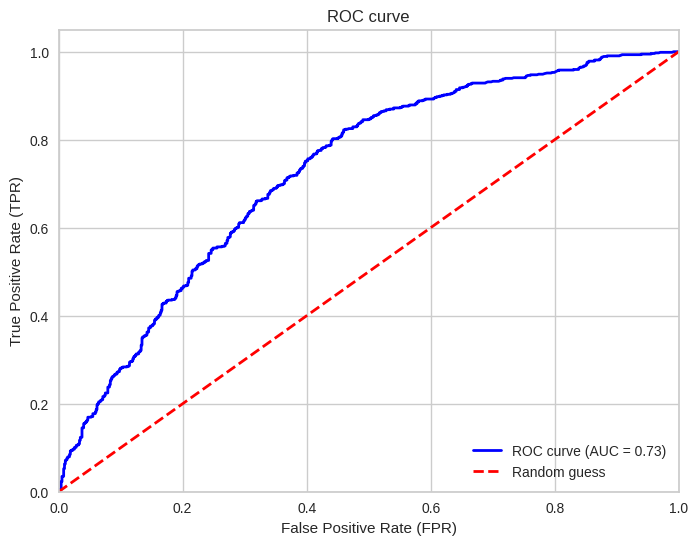

In [44]:
# Plotting the ROC curve
plt.figure(figsize=(8, 6))
plt.plot(false_positive_rate, true_positive_rate, color='blue', lw=2, label='ROC curve (AUC = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='red', lw=2, linestyle='--', label='Random guess')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate (FPR)')
plt.ylabel('True Positive Rate (TPR)')
plt.title('ROC curve')
plt.legend(loc='lower right')
plt.show()

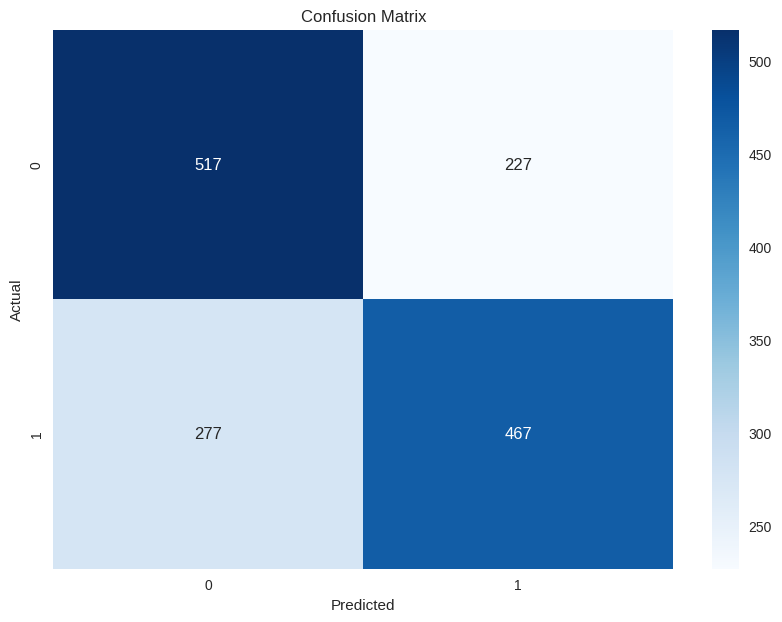

In [45]:
# Making predictions on the test set
test_predictions = bayesian_optimizer.predict(x_test)

# Confusion matrix
confusion = confusion_matrix(y_test, test_predictions)

# Plotting the confusion matrix using seaborn for a more elegant visualization
plt.figure(figsize=(10, 7))
sns.heatmap(confusion, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

The confusion matrix result reveals that the model is showing reasonable performance in distinguishing between classes 0 and 1. However, considering that the classifier's objective is to identify muons, the information loss when a muon is incorrectly classified as non-muon is significant, highlighting the need for model improvement.

### Comparing the Models

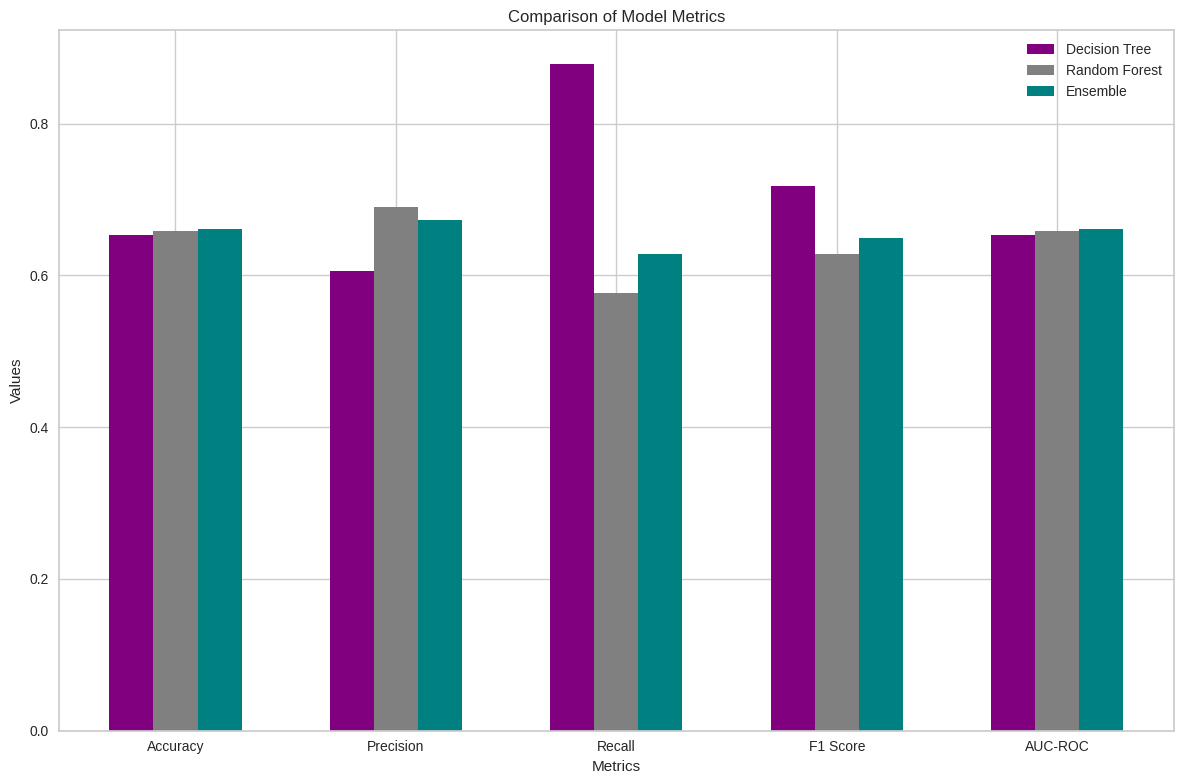

In [46]:
# Function to calculate metrics for a set of predictions
def calculate_metrics(y_true, y_pred):
    metrics = {
        "Accuracy": accuracy_score(y_true, y_pred),
        "Precision": precision_score(y_true, y_pred),
        "Recall": recall_score(y_true, y_pred),
        "F1 Score": f1_score(y_true, y_pred),
        "AUC-ROC": roc_auc_score(y_true, y_pred)
    }
    return metrics

# Decision Tree
yhat_train_dt = bayes_search.best_estimator_.predict(x_train)
yhat_test_dt = bayes_search.best_estimator_.predict(x_test)
metrics_dt = calculate_metrics(y_test, yhat_test_dt)

# Random Forest
train_predictions_rf = optimal_model.predict(x_train)
test_predictions_rf = optimal_model.predict(x_test)
metrics_rf = calculate_metrics(y_test, test_predictions_rf)

# Decision Tree and Random Forest Ensemble
predictions_train_ensemble = selected_model.predict(x_train)
predictions_test_ensemble = selected_model.predict(x_test)
metrics_ensemble = calculate_metrics(y_test, predictions_test_ensemble)

# Compile metrics
models = ["Decision Tree", "Random Forest", "Ensemble"]
metrics_names = list(metrics_dt.keys())
values = np.array([
    [metrics_dt[metric] for metric in metrics_names],
    [metrics_rf[metric] for metric in metrics_names],
    [metrics_ensemble[metric] for metric in metrics_names]
])

# Set up the graph
fig, ax = plt.subplots(figsize=(12, 8))
bar_width = 0.2
index = np.arange(len(metrics_names))

# Custom colors
colors = ['purple', 'gray', 'teal']

# Plot the bars for each model
for i, (model, color) in enumerate(zip(models, colors)):
    ax.bar(index + i * bar_width, values[i], bar_width, label=model, color=color)

# Add labels and title
ax.set_xlabel('Metrics')
ax.set_ylabel('Values')
ax.set_title('Comparison of Model Metrics')
ax.set_xticks(index + bar_width)
ax.set_xticklabels(metrics_names)
ax.legend()

# Adjust layout and save the graph as an image
plt.tight_layout()
plt.savefig('model_comparison_metrics.png', format='png')

# Display the graph
plt.show()

Comparing the models, it is noticeable that the decision tree model had significantly higher recall and F1-score, as it managed to correctly classify many muon events (class 1) with few muons incorrectly classified as non-muons. On the other hand, the Random Forest model achieved slightly higher precision, and AUC compared to the other models. Additionally, the ensemble of models reached an slightly higher accuracy compared to the other models.

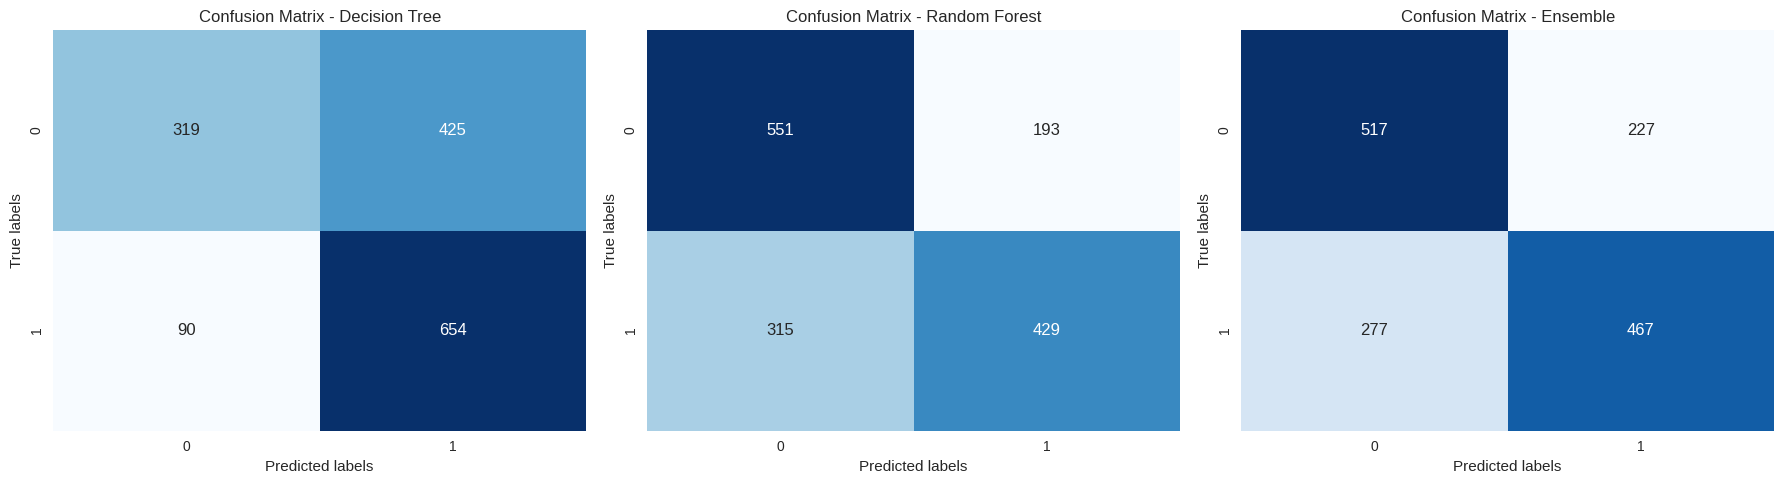

In [47]:
# Function to plot confusion matrix
def plot_confusion_matrix(cm, ax, model_name):
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', ax=ax, cbar=False)
    ax.set_xlabel('Predicted labels')
    ax.set_ylabel('True labels')
    ax.set_title(f'Confusion Matrix - {model_name}')

# Decision Tree
yhat_train_dt = bayes_search.best_estimator_.predict(x_train)
yhat_test_dt = bayes_search.best_estimator_.predict(x_test)
cm_dt = confusion_matrix(y_test, yhat_test_dt)

# Random Forest
train_predictions_rf = optimal_model.predict(x_train)
test_predictions_rf = optimal_model.predict(x_test)
cm_rf = confusion_matrix(y_test, test_predictions_rf)

# Ensemble de Decision Tree e Random Forest
predictions_train_ensemble = selected_model.predict(x_train)
predictions_test_ensemble = selected_model.predict(x_test)
cm_ensemble = confusion_matrix(y_test, predictions_test_ensemble)

# Plotting the matrix of confusion
fig, axes = plt.subplots(1, 3, figsize=(18, 5))

# Plotting each matrix of confusion
plot_confusion_matrix(cm_dt, axes[0], 'Decision Tree')
plot_confusion_matrix(cm_rf, axes[1], 'Random Forest')
plot_confusion_matrix(cm_ensemble, axes[2], 'Ensemble')

plt.tight_layout()
plt.savefig('confusion_matrix_comparison.png', format='png')
plt.show()

The decision tree model can be utilized because it performed well in correctly classifying muons. However, post-processing is necessary to remove particles incorrectly classified as muons due to the model's difficulty in clearly distinguishing between classes. On the other hand, the Random Forest model showed acceptable precision, recall, and F1-score, with results similar to those obtained with the ensemble of models. Additionally, Random Forest is computationally less expensive to train, which may make it preferable compared to the ensemble. Given the impacts of using an imbalanced dataset during training, the trained models can be improved by retraining with new data, particularly with more examples of muons to balance the classes. Despite using SMOTE technique, the synthetic data created may not capture all the nuances of real data, which can affect the model's ability to generalize to unseen data during training. For these reasons, both models will be registered in MLflow to facilitate further model improvement using new data.

### Recording Models in MLflow

MLflow is an open-source platform designed to manage the machine learning (ML) lifecycle. It allows systematic logging and tracking of ML experiments, facilitating model comparison, reproducibility of previous experiments, and efficient deployment of models into production.

In the context of MLflow, metrics are numeric values that quantify the performance of a model during different phases such as training, evaluation, or inference, including measures like accuracy, recall, and F1-score. They are logged using `mlflow.log_metric()` and are used to compare models, hyperparameters, and iterations within an experiment. Parameters are adjustable variables that influence the behavior of a model, such as learning rate and decision tree depth, logged with `mlflow.log_param()` to document specific configurations used in each execution and facilitate experiment reproducibility. Artifacts are files or resources generated during the experiment lifecycle, such as confusion matrix plots, trained models, and CSV result files, logged with `mlflow.log_artifact()` to capture relevant visualizations and documents, aiding in auditing, reviewing, and sharing results and resources associated with the developed model.

In [48]:
# Configure MLflow to use SQLite as the tracking repository
mlflow.set_tracking_uri("sqlite:///mlruns.db")

# Define experiment name
experiment_name = 'Experiment Opera'

# Initialize MLflow client
client = MlflowClient()

# Check if the experiment already exists
experiment = client.get_experiment_by_name(experiment_name)

if experiment:
    # If the experiment exists, get its ID
    experiment_id = experiment.experiment_id
    print(f"Experiment '{experiment_name}' already exists with ID {experiment_id}")
else:
    # If the experiment does not exist, create it
    experiment_id = client.create_experiment(experiment_name)
    print(f"Experiment '{experiment_name}' created with ID {experiment_id}")

# Get the experiment ID for further use
experiment = client.get_experiment(experiment_id)
experiment_id = experiment.experiment_id

2024/08/21 19:15:28 INFO mlflow.store.db.utils: Creating initial MLflow database tables...
2024/08/21 19:15:28 INFO mlflow.store.db.utils: Updating database tables
INFO  [alembic.runtime.migration] Context impl SQLiteImpl.
INFO  [alembic.runtime.migration] Will assume non-transactional DDL.
INFO  [alembic.runtime.migration] Running upgrade acf3f17fdcc7 -> 867495a8f9d4, add trace tables
INFO  [alembic.runtime.migration] Running upgrade 867495a8f9d4 -> 5b0e9adcef9c, add cascade deletion to trace tables foreign keys
INFO  [alembic.runtime.migration] Context impl SQLiteImpl.
INFO  [alembic.runtime.migration] Will assume non-transactional DDL.


Experiment 'Experiment Opera' already exists with ID 1


#### Decision Tree

In [49]:
# Calculate the metrics
metrics_train = {
    "Accuracy": accuracy_score(y_train, yhat_train),
    "Precision": precision_score(y_train, yhat_train),
    "Recall": recall_score(y_train, yhat_train),
    "F1 Score": f1_score(y_train, yhat_train),
    "AUC-ROC": roc_auc_score(y_train, yhat_train)
}

metrics_test = {
    "Accuracy": accuracy_score(y_test, yhat_test),
    "Precision": precision_score(y_test, yhat_test),
    "Recall": recall_score(y_test, yhat_test),
    "F1 Score": f1_score(y_test, yhat_test),
    "AUC-ROC": roc_auc_score(y_test, yhat_test)
}

# Plot the ROC curve
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (area = {auc_score:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right")
plt.grid(True)

# Save the ROC curve figure as a temporary file
roc_plot_file = '/tmp/roc_curve.png'
plt.savefig(roc_plot_file)
plt.close()

# Calculate and plot the confusion matrix
cm = confusion_matrix(y_test, yhat_test)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, cmap="Blues", fmt="d", cbar=False)
plt.title("Matriz de Confusão")
plt.xlabel("Predicted Labels")
plt.ylabel("True Labels")
plt.tight_layout()

# Save the confusion matrix Plot as a temporary file
confusion_matrix_plot = "/tmp/confusion_matrix.png"
plt.savefig(confusion_matrix_plot)
plt.close()

# Record trained model and metrics in MLflow
with mlflow.start_run(experiment_id=experiment_id):
    
    # Log of hyperparameters of the best model found
    mlflow.log_params(best_params)
    
    # Log of model metrics in training data
    for metric_name, metric_value in metrics_train.items():
        mlflow.log_metric(f"train_{metric_name}", metric_value)
    
    # Log of model metrics in test data
    for metric_name, metric_value in metrics_test.items():
        mlflow.log_metric(f"test_{metric_name}", metric_value)
    
    # Save the model
    mlflow.sklearn.log_model(bayes_search.best_estimator_, "decision_tree_model")
    
    # Register the ROC curve as an artifact
    mlflow.log_artifact(roc_plot_file, artifact_path="plots")

    # Register the confusion matrix as an artifact
    mlflow.log_artifact(confusion_matrix_plot, artifact_path="plots")
    
print("Model, metrics, ROC curve and confusion matrix recorded in MLflow successfully.")

2024/08/21 19:15:32 WARNING mlflow.utils.requirements_utils: Found lz4 version (3.1.3+dfsg) contains a local version label (+dfsg). MLflow logged a pip requirement for this package as 'lz4==3.1.3' without the local version label to make it installable from PyPI. To specify pip requirements containing local version labels, please use `conda_env` or `pip_requirements`.


Model, metrics, ROC curve and confusion matrix recorded in MLflow successfully.


#### Random Forest

In [52]:
import os
import mlflow
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score

# Calcular as métricas para o conjunto de treinamento
metrics_train_rf = {
    "Accuracy": accuracy_score(y_train, train_predictions),
    "Precision": precision_score(y_train, train_predictions),
    "Recall": recall_score(y_train, train_predictions),
    "F1 Score": f1_score(y_train, train_predictions),
    "AUC-ROC": roc_auc_score(y_train, train_predictions)
}

# Calcular as métricas para o conjunto de teste
metrics_test_rf = {
    "Accuracy": accuracy_score(y_test, test_predictions),
    "Precision": precision_score(y_test, test_predictions),
    "Recall": recall_score(y_test, test_predictions),
    "F1 Score": f1_score(y_test, test_predictions),
    "AUC-ROC": roc_auc_score(y_test, test_predictions)
}

# Plotar a curva ROC
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (area = {roc_auc_rf:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right")
plt.grid(True)

# Salvar a curva ROC como um arquivo temporário
roc_plot_rf_file = '/tmp/roc_curve_rf.png'
plt.savefig(roc_plot_rf_file)
plt.close()

# Calcular e plotar a matriz de confusão
plt.figure(figsize=(8, 6))
sns.heatmap(cm_rf, annot=True, cmap="Blues", fmt="d", cbar=False)
plt.title("Matriz de Confusão")
plt.xlabel("Predicted Labels")
plt.ylabel("True Labels")
plt.tight_layout()

# Corrigir o nome da variável de arquivo para salvar a matriz de confusão
confusion_matrix_plot_rf = "/tmp/confusion_matrix_rf.png"
plt.savefig(confusion_matrix_plot_rf)
plt.close()

# Registrar modelo treinado e métricas no MLflow
with mlflow.start_run(experiment_id=experiment_id):
    
    # Log dos hiperparâmetros do melhor modelo encontrado
    mlflow.log_params(optimal_params)
    
    # Log das métricas do modelo nos dados de treinamento
    for metric_name, metric_value in metrics_train_rf.items():
        mlflow.log_metric(f"train_{metric_name}", metric_value)
    
    # Log das métricas do modelo nos dados de teste
    for metric_name, metric_value in metrics_test_rf.items():
        mlflow.log_metric(f"test_{metric_name}", metric_value)
    
    # Salvar o modelo
    mlflow.sklearn.log_model(bayesian_search.best_estimator_, "random_forest_model")
    
    # Registrar a curva ROC como um artefato
    mlflow.log_artifact(roc_plot_rf_file, artifact_path="plots")

    # Registrar a matriz de confusão como um artefato
    mlflow.log_artifact(confusion_matrix_plot_rf, artifact_path="plots")
    
print("Modelo, métricas, curva ROC e matriz de confusão registrados no MLflow com sucesso.")

2024/08/21 19:26:04 WARNING mlflow.utils.requirements_utils: Found lz4 version (3.1.3+dfsg) contains a local version label (+dfsg). MLflow logged a pip requirement for this package as 'lz4==3.1.3' without the local version label to make it installable from PyPI. To specify pip requirements containing local version labels, please use `conda_env` or `pip_requirements`.


Modelo, métricas, curva ROC e matriz de confusão registrados no MLflow com sucesso.


#### Ensemble Models

In [53]:
# Calculate the metrics
metrics_train_ensemble = {
    "Accuracy": accuracy_score(y_train, predictions_train),
    "Precision": precision_score(y_train, predictions_train),
    "Recall": recall_score(y_train, predictions_train),
    "F1 Score": f1_score(y_train, predictions_train),
    "AUC-ROC": roc_auc_score(y_train, predictions_train)
}

metrics_test_ensemble = {
    "Accuracy": accuracy_score(y_test, predictions_test),
    "Precision": precision_score(y_test, predictions_test),
    "Recall": recall_score(y_test, predictions_test),
    "F1 Score": f1_score(y_test, predictions_test),
    "AUC-ROC": roc_auc_score(y_test, predictions_test)
}

# Plot the ROC curve
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (area = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right")
plt.grid(True)

# Save the ROC curve figure as a temporary file
roc_plot_ensemble_file = '/tmp/roc_curve_ensemble.png'
plt.savefig(roc_plot_ensemble_file)
plt.close()

# Calculate and plot the confusion matrix for test data
confusion = confusion_matrix(y_test, predictions_test)
plt.figure(figsize=(8, 6))
sns.heatmap(confusion, annot=True, cmap="Blues", fmt="d", cbar=False)
plt.title("Matriz de Confusão")
plt.xlabel("Predicted Labels")
plt.ylabel("True Labels")
plt.tight_layout()

# Save the confusion matrix Plot as a temporary file
confusion_matrix_plot_ensemble = "/tmp/confusion_matrix_ensemble.png"
plt.savefig(confusion_matrix_plot_ensemble)
plt.close()

with mlflow.start_run(experiment_id=experiment_id):
    
    # Log of model metrics in training data
    for metric_name, metric_value in metrics_train_ensemble.items():
        mlflow.log_metric(f"train_{metric_name}", metric_value)
    
    # Log of model metrics in test data
    for metric_name, metric_value in metrics_test_ensemble.items():
        mlflow.log_metric(f"test_{metric_name}", metric_value)
    
    # Save the model
    mlflow.sklearn.log_model(bayesian_optimizer.best_estimator_, "Ensemble_model")
    
    # Register the ROC curve as an artifact
    mlflow.log_artifact(roc_plot_ensemble_file, artifact_path="plots")

    # Register the confusion matrix as an artifact
    mlflow.log_artifact(confusion_matrix_plot_ensemble, artifact_path="plots")
    
print("Model, metrics, ROC curve and confusion matrix recorded in MLflow successfully.")

2024/08/21 19:26:28 WARNING mlflow.utils.requirements_utils: Found lz4 version (3.1.3+dfsg) contains a local version label (+dfsg). MLflow logged a pip requirement for this package as 'lz4==3.1.3' without the local version label to make it installable from PyPI. To specify pip requirements containing local version labels, please use `conda_env` or `pip_requirements`.


Model, metrics, ROC curve and confusion matrix recorded in MLflow successfully.
